2-1_2


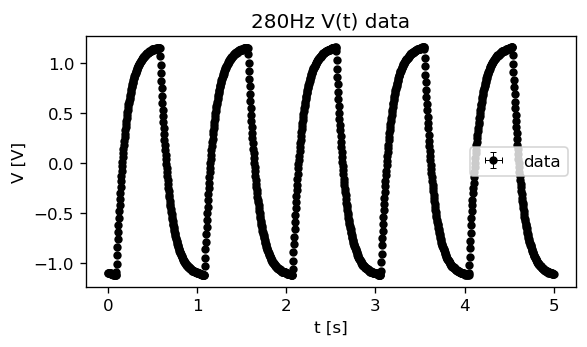

2-2_1.5Hz_2


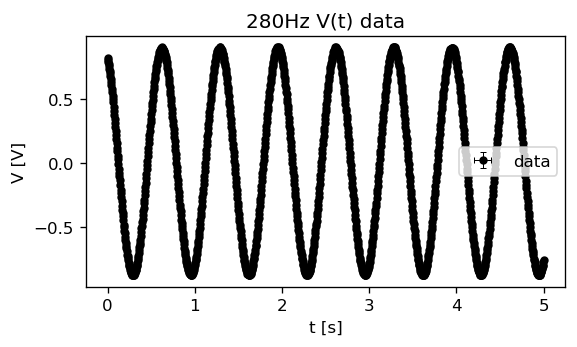

2-2_10Hz_2


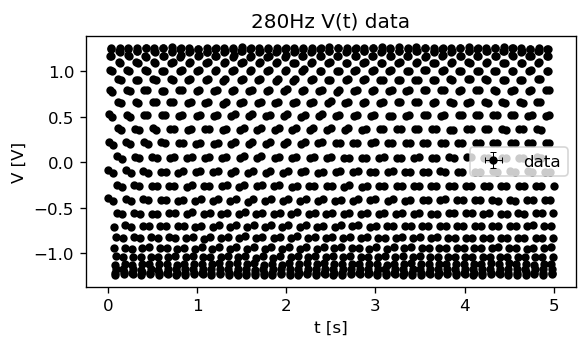

2-2_15Hz_2


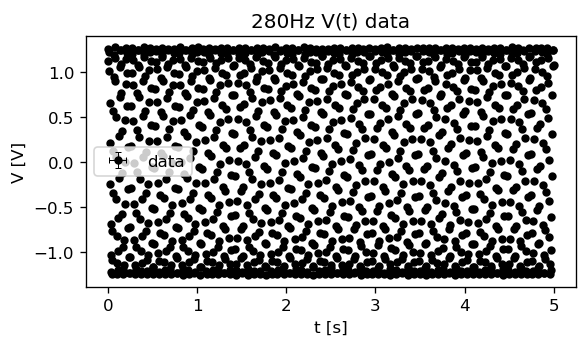

2-2_1Hz_2


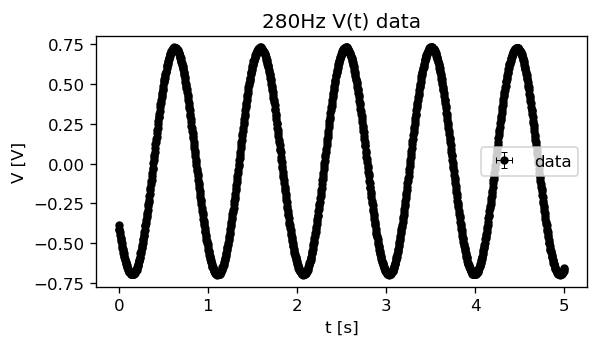

2-2_2.5Hz_2


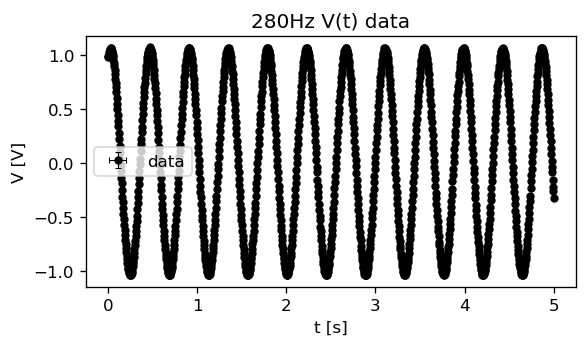

2-2_20Hz_2


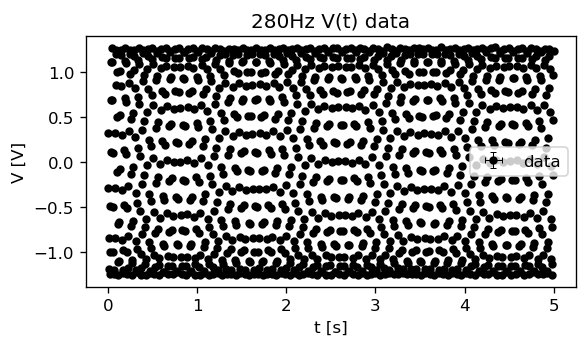

2-2_2Hz_2


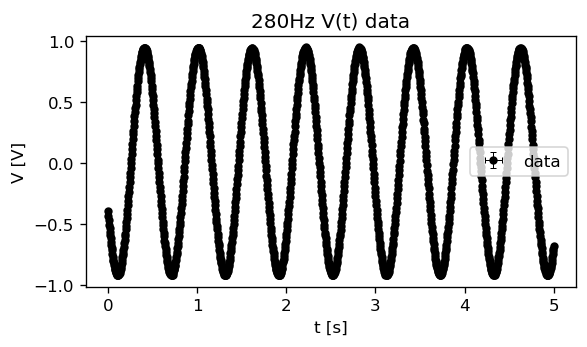

2-2_30Hz_2


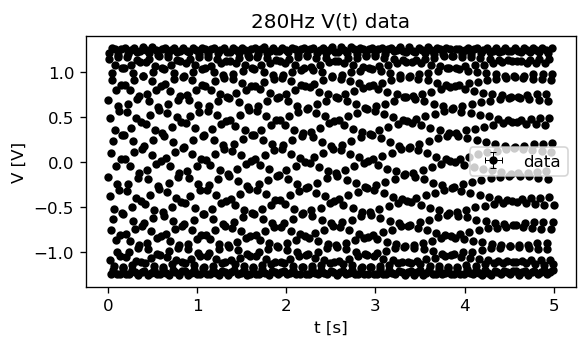

2-2_3Hz_2


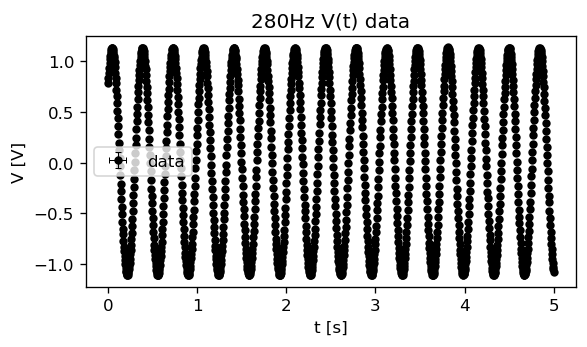

2-2_4Hz_2


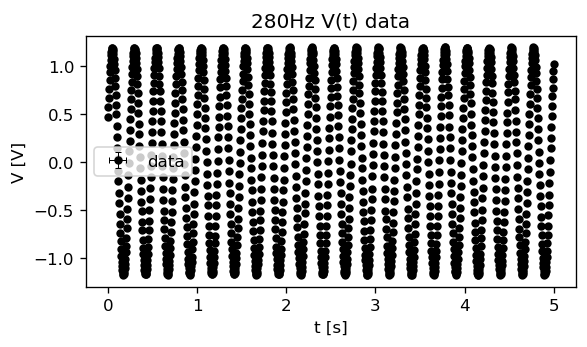

2-2_5Hz_2


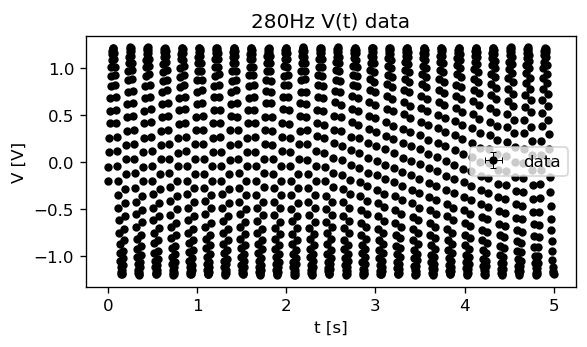

2-2_6Hz_2


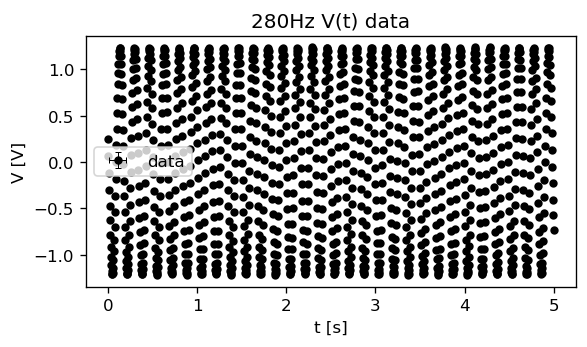

2-2_7Hz_2


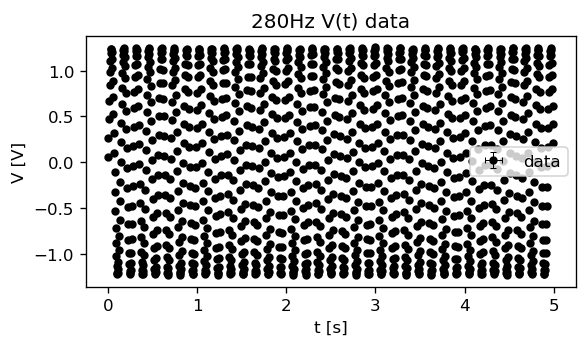

2-2_8Hz_2


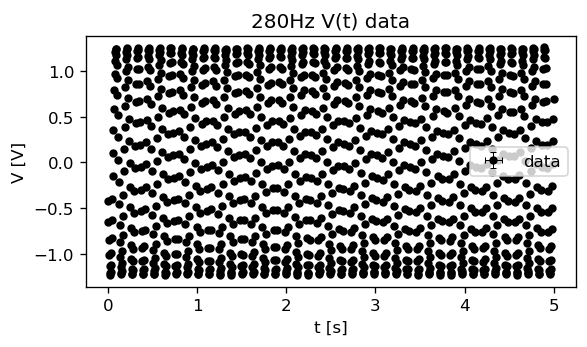

2-2_9Hz_2


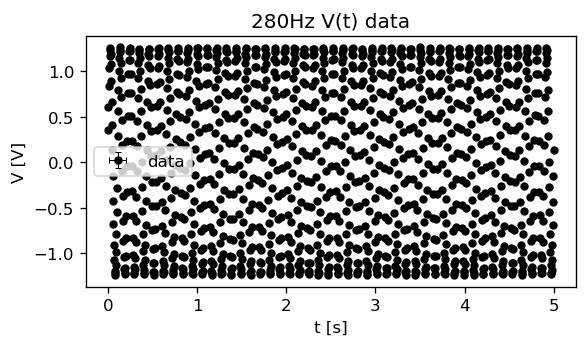

2-3_100Hz_2


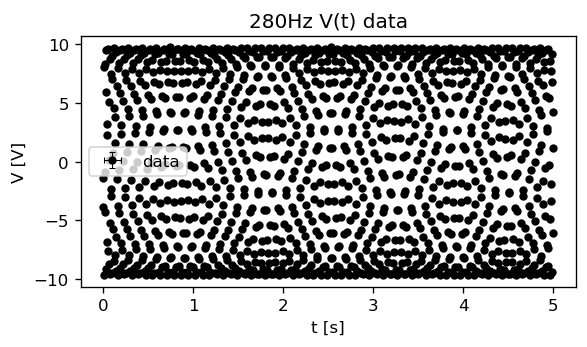

2-3_200Hz_2


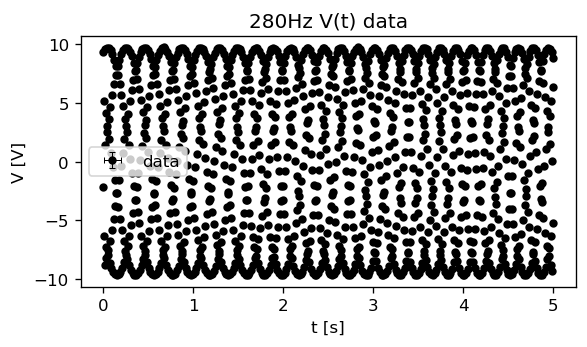

2-3_210Hz_2


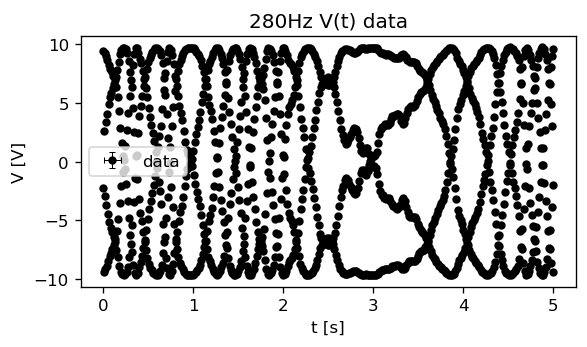

2-3_220Hz_2


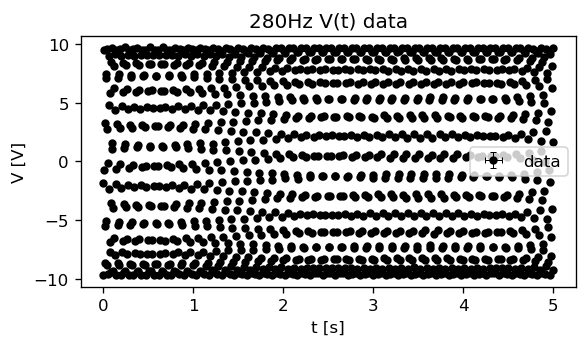

2-3_240Hz_2


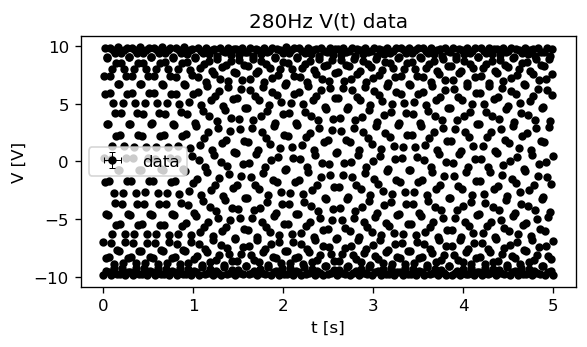

2-3_250Hz_2


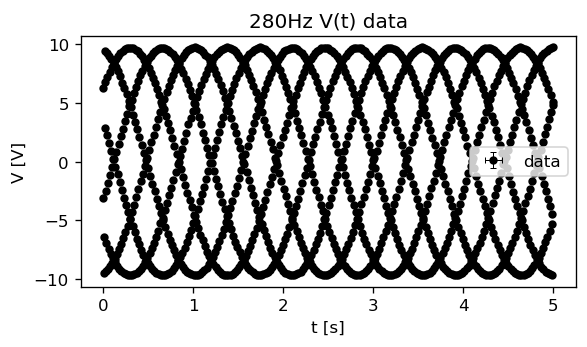

2-3_280Hz_2


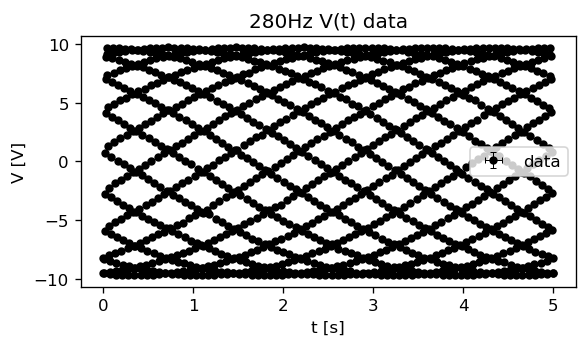

2-3_300Hz_2


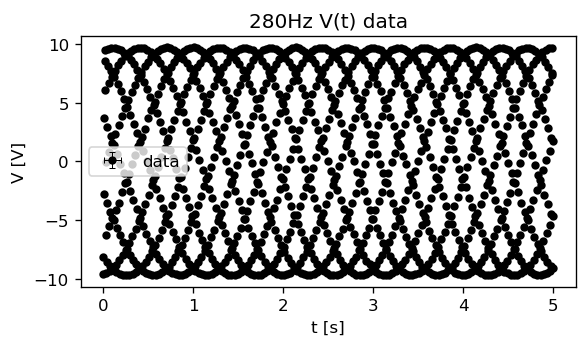

2-4_100Hz_2


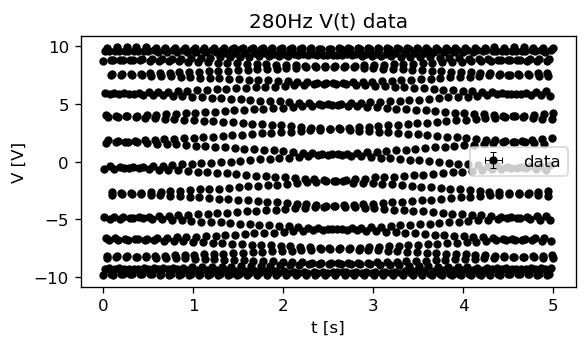

2-4_150Hz_2


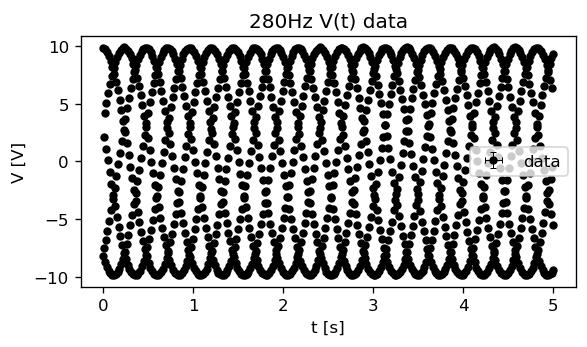

2-4_160Hz_2


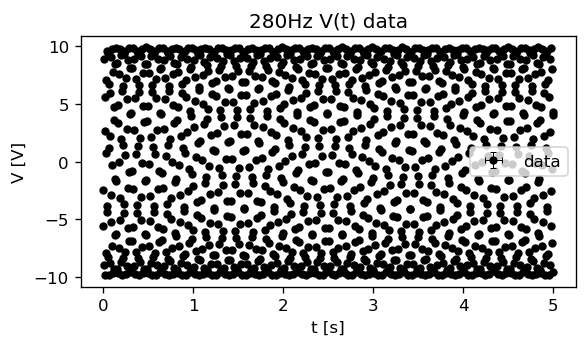

2-4_170Hz_2


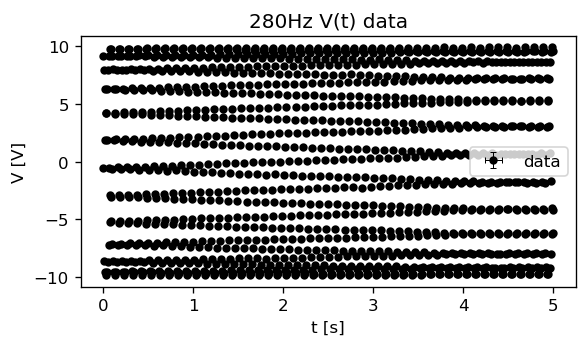

2-4_180Hz_2


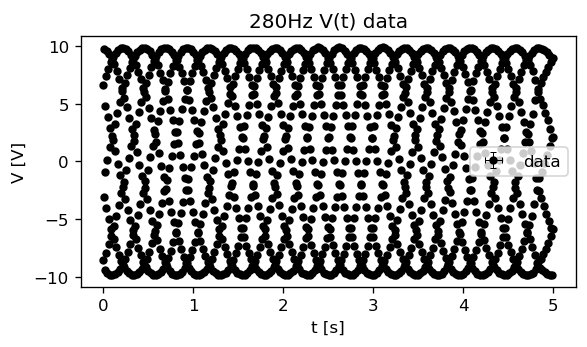

2-4_190Hz_2


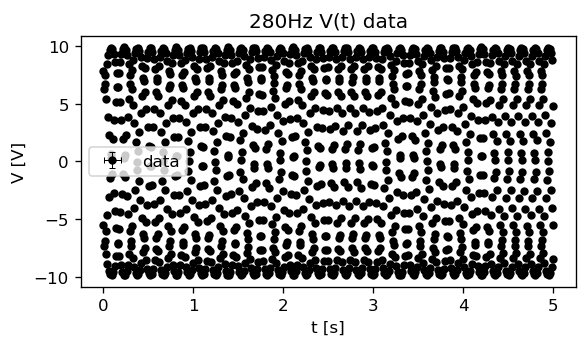

2-4_195Hz_2


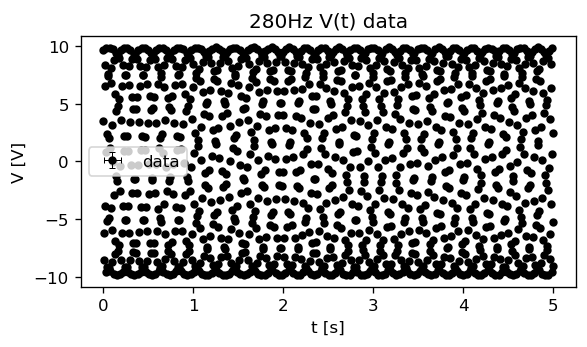

2-4_200Hz_2


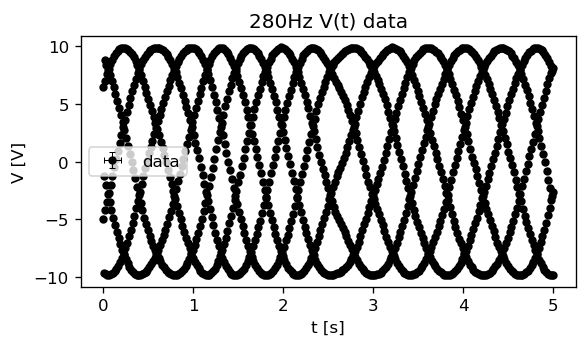

2-4_250Hz_2


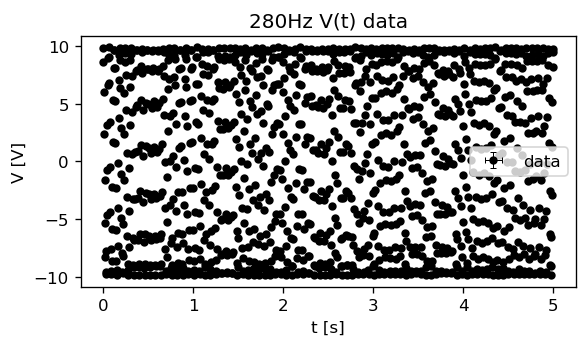

2-4_300Hz_2


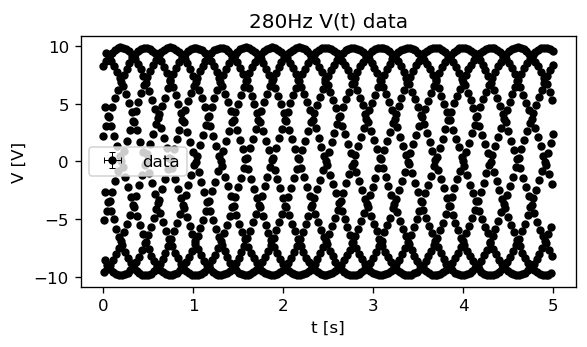

2-5_100Hz_2


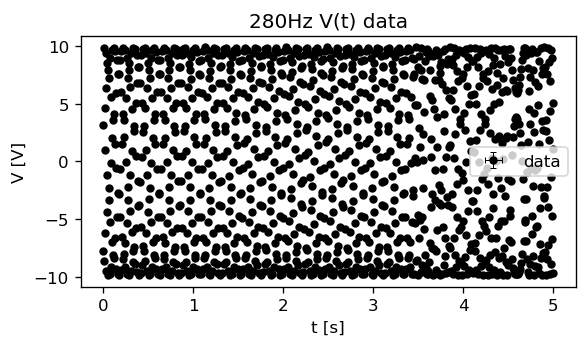

2-5_150Hz_2


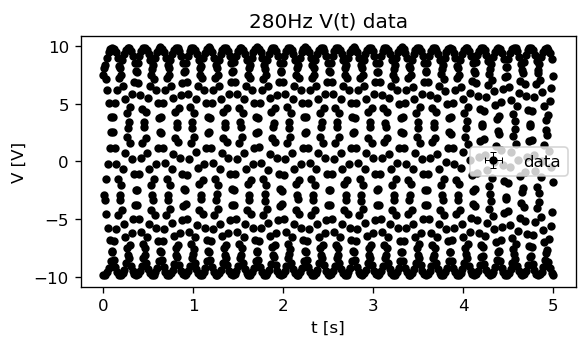

2-5_160Hz_2


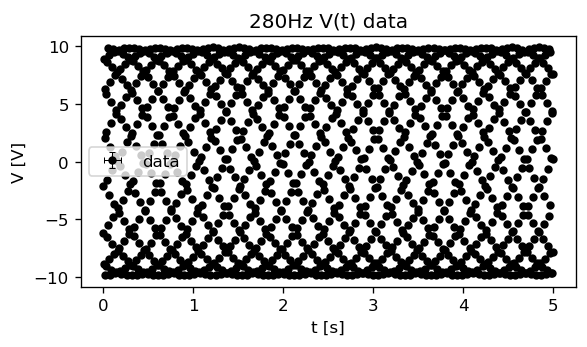

2-5_170Hz_2


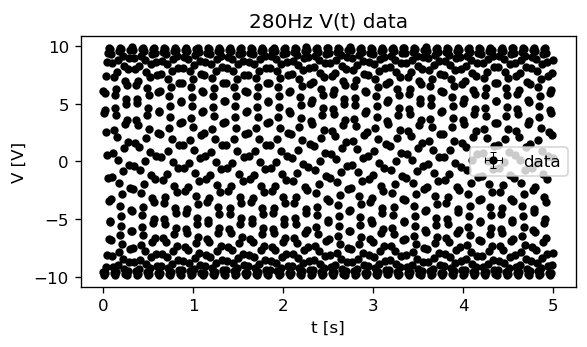

2-5_180Hz_2


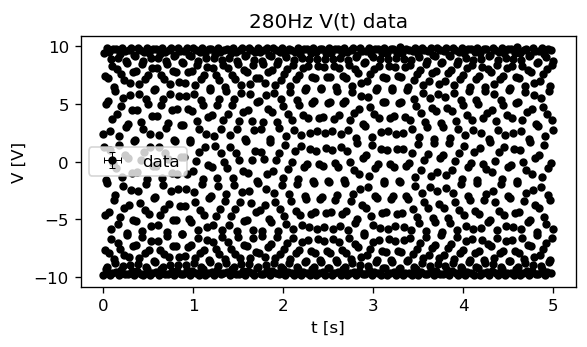

2-5_185Hz_2


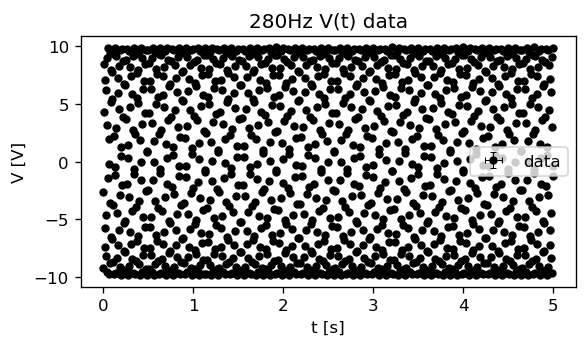

2-5_190Hz_2


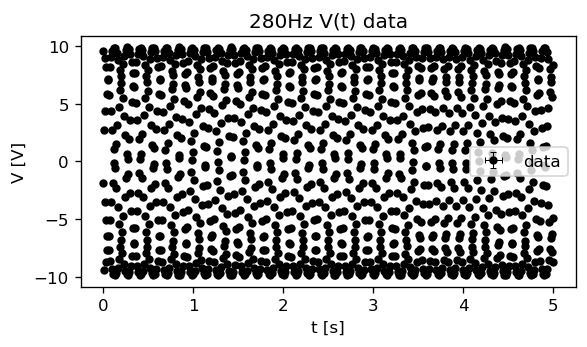

2-5_200Hz_2


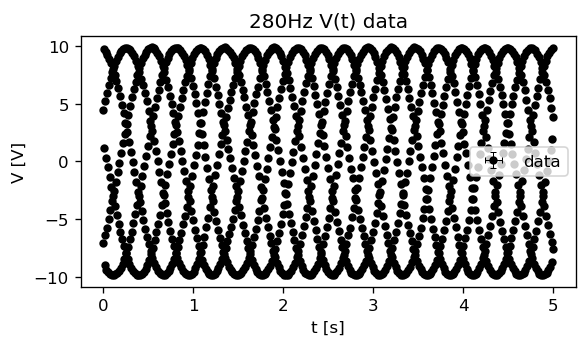

In [20]:
import fit_classes as fp
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt


errors = []
ERROR = 0.0001 
def data_from_file(file):
    file_path = os.path.join(os.path.dirname(os.path.abspath(os.getcwd())), file)
    name = str(file_path).split("/")[-1].split("\\")[-1]
    df = pd.read_csv(file_path, delimiter=';', decimal=',')
    df.columns = df.columns.str.strip()

    SKIP1 = 1
    SKIP2_ =1
    SKIP2 = SKIP2_

    file_p = os.path.join(os.path.abspath(os.getcwd()), "data", "superposition.txt")
    vals = []
    var = None
    with open(file_p, "r") as file:
        for line in file:
            vals.append((line.strip().split(": ")[0],tuple(map(int, line.strip().split(": ")[-1].strip("()").split(", ")))))

    # check = False

    # for var in vals:
    #     if var[0] == name:
    #         SKIP1, SKIP2 = var[1]
    #         check = True

    # if not check:
    #     if True:
    #         values = (SKIP1, SKIP2)
    #         with open(file_p, "a") as file:
    #             file.write(f"{name}: {values}\n")

    x1 = df["Latest: Time (s)"].to_numpy()[::SKIP1]
    x2 = df["Latest: Time (s)"].to_numpy()[::SKIP2]
    y1 = df["Latest: Potential 1 (V)"].to_numpy()[::SKIP1]
    y2 = df["Latest: Potential 2 (V)"].to_numpy()[::SKIP2]
    dy1 = ERROR*np.ones_like(y1)
    dy2 = ERROR*np.ones_like(y2)

    # data1 = fp.Data(x1, y1, dy1, name=str(file_path).split('/')[-1][0:-4].split("\\")[-1] + '_1')
    # data2 = fp.Data(x2, y2, dy2, name=str(file_path).split('/')[-1][0:-4].split("\\")[-1]  + '_2')
    data1 = fp.Data(x1, y1, dy1, name=os.path.splitext(os.path.basename(file_path))[0] + '_1')
    data2 = fp.Data(x2, y2, dy2, name=os.path.splitext(os.path.basename(file_path))[0] + '_2')
    data2.input = y1

    if not check:
        print(data2.name)
        data2.show(title='280Hz V(t) data', x_label='t [s]', y_label='V [V]')
    return data1, data2

        
def load_data_by_folder(root):
    folder_data = {}
    total_files = 0
    total_files += len([f for f in os.listdir(root)])

    current_file = 0
    data_list_input = []
    data_list = []
    for file in os.listdir(root):
        file_path = os.path.join(root, file)
        if os.path.isfile(file_path) and file.lower().endswith(".csv"):
            current_file += 1
            # os.system(f'echo "File: {current_file:>3}/{total_files}"')
            data1, data2 = data_from_file(file_path)
            data_list_input.append(data1)
            data_list.append(data2)
        
    if data_list:
        folder_data = np.array(data_list)
    return folder_data

data_arrays = load_data_by_folder(os.path.join(os.path.abspath(os.getcwd()), "data"))


In [2]:
datadict = {}
for dataset in data_arrays:
    datadict[dataset.name[0:-2]] = dataset # ON windows
    # if dataset[1].name == '2-5_190Hz_2':
    # print(dataset.name)
    # dataset.show()
         
print(datadict["2-3_250Hz"])

2-3_250Hz_2:
0.0	6.26373626374
0.024	6.74236874237
0.048	7.22588522589
0.072	7.67032967033
0.096	8.07081807082
0.12	8.4126984127
0.144	8.73992673993
0.168	9.00366300366
0.192	9.23321123321
0.216	9.42368742369
0.24	9.56043956044
0.264	9.65811965812
0.288	9.72161172161
0.312	9.71672771673
0.336	9.64835164835
0.36	9.54578754579
0.384	9.39438339438
0.408	9.20390720391
0.432	8.95970695971
0.456	8.6862026862
0.48	8.37362637363
0.504	8.00732600733
0.528	7.5873015873
0.552	7.16239316239
0.576	6.68376068376
0.6	6.18070818071
0.624	5.65811965812
0.648	5.08669108669
0.672	4.51526251526
0.696	3.89010989011
0.72	3.26984126984
0.744	2.64957264957
0.768	1.99511599512
0.792	1.31135531136
0.816	0.656898656899
0.84	-0.002442002442
0.864	-0.681318681319
0.888	-1.33089133089
0.912	-2.00488400488
0.936	-2.67399267399
0.96	-3.28449328449
0.984	-3.91941391941
1.008	-4.54456654457
1.032	-5.12576312576
1.056	-5.70207570208
1.08	-6.23443223443
1.104	-6.7326007326
1.128	-7.21611721612
1.152	-7.6800976801
1.176	-

# Opgave 1

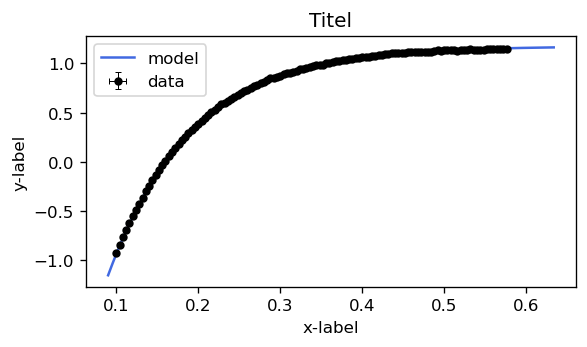

----------------------------------------------------------------------------------------------------------------
For parameter tau      :     $      0.10244 \pm      0.00039 $
For parameter a        :     $      1.17432 \pm      0.00180 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min          51.20400389
Reduced χ² value       :     χ²_red           0.43393224
P-value                :     p-value          0.99999999
----------------------------------------------------------------------------------------------------------------



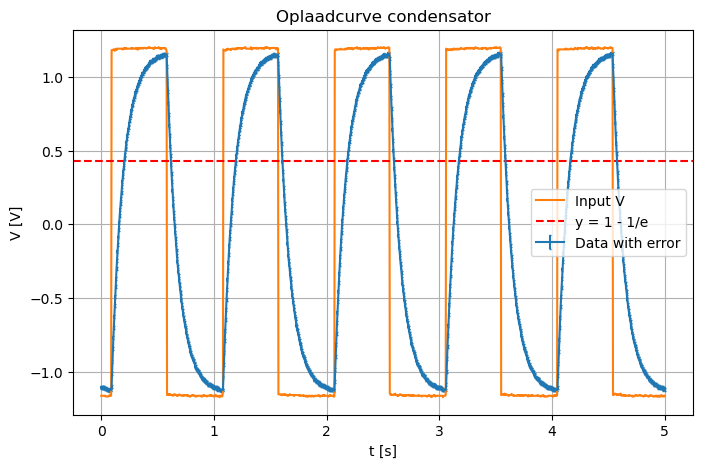

In [3]:
ERROR = 0.01
dataset = fp.Data(datadict["2-1"].x[25:145], datadict["2-1"].y[25:145], ERROR*datadict["2-1"].dy[25:145])
volle_data=fp.Data(datadict["2-1"].x, datadict["2-1"].y, ERROR*datadict["2-1"].dy)

def model_opgave1(params, x):
    tau,a = params
    return (1-np.exp(-(x-0.160)/tau))*a

dataset.fit(model_opgave1).show()
print(dataset.fit(model_opgave1))
# volle_data.show()

x=datadict["2-1"].x
y = datadict["2-1"].y
y2=datadict["2-1"].input
y_err=0.01
plt.figure(figsize=(8, 5))

plt.errorbar(x, y, yerr=y_err,  capsize=1, label='Data with error')
plt.plot(x, y2, label='Input V')
plt.axhline(y=1/np.e*1.17, color='r', linestyle='--', label='y = 1 - 1/e')

plt.xlabel('t [s]')
plt.ylabel('V [V]')
plt.title('Oplaadcurve condensator')
plt.legend()
plt.grid(True)

plt.show()


# Opgave 2

In [4]:
ERROR = 0.01
files = []
files_opdracht2 = []
for key in datadict:
    if key[0:3] == "2-2":
        files.append(fp.Data(datadict[key].x, datadict[key].y, ERROR*datadict[key].dy, name=datadict[key].name))

def sinus_model(params, x):
    A,f,phi,c = params
    return A*np.sin(2*np.pi*f*x + phi) + c

        
for dataset in files:
    A = 1.25
    f = 6
    phi = np.pi
    c = 0

    file_p = os.path.join(os.path.abspath(os.getcwd()), "data", "guesses_opgave2.txt")
    vals = []
    var = None
    check = True

    with open(file_p, "r") as file:
        for line in file:
            vals.append((line.strip().split(": ")[0],tuple(map(float, line.strip().split(": ")[-1].strip("()").split(", ")))))
    for var in vals:
        if var[0] == dataset.name:
            A, f, phi, c = var[1]
            check = False

    dataset_new = dataset.fit(sinus_model, initial_guess=[A, f, phi, c])
    files_opdracht2.append(dataset_new)
    if dataset_new.chi2_red > 10:
        check = False
            
    if check:
        values = tuple([_ for _ in dataset_new.minima])
        with open(file_p, "a") as file:
            file.write(f"{dataset.name}: {values}\n")

    # WARNING: shows all fits
    if dataset_new.chi2_red > 0:
        print(dataset.name)
        print(dataset_new)
        # dataset_new.show(size=1)
        print()
        print("\n\n\n")

2-2_1.5Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $      0.88560 \pm      0.00087 $
For parameter f        :     $      1.50309 \pm      0.00005 $
For parameter phi      :     $      1.98181 \pm      0.00098 $
For parameter c        :     $      0.00949 \pm      0.00061 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min         490.35261397
Reduced χ² value       :     χ²_red           0.39322583
P-value                :     p-value          1.00000000
----------------------------------------------------------------------------------------------------------------






2-2_10Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $      1.24865 \pm      0.00087 $
For parameter f        :     $   

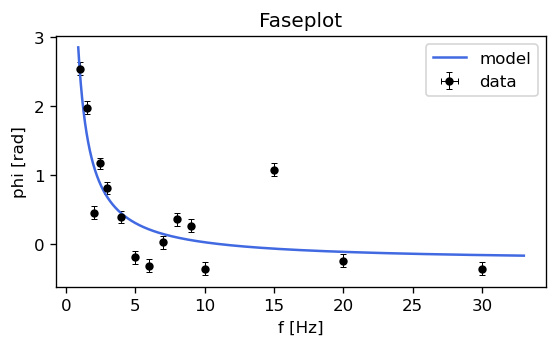

----------------------------------------------------------------------------------------------------------------
For parameter A        :     $      0.98239 \pm      0.03549 $
For parameter B        :     $     -0.05642 \pm      0.00323 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min         907.56955001
Reduced χ² value       :     χ²_red          69.81304231
P-value                :     p-value          0.00000000
----------------------------------------------------------------------------------------------------------------



In [5]:

def amplitude_model(params, x):
    tau,a = params
    return a*tau*x/(np.sqrt(1+ tau**2*x**2))
def phi_model(params, x):
    tau,c=params
    return 1/(tau*x)+c

A_lst=[0.71225,0.88560,0.92924 ,1.047561 , 1.11749,1.18034, 1.20992, 1.22187,  1.23368 ,1.24062 , 1.24495 ,1.24865, 1.25598, 1.25889,1.25532]
A_err=[0.0186 ,0.0187,0.0186, 0.0187 ,0.0187 ,0.0187, 0.0187, 0.0187, 0.0187, 0.0187, 0.0187, 0.0187, 0.0187, 0.0187, 0.0187 ]
freq_lst=[1,1.5,2,2.5,3,4,5,6,7,8,9,10,15,20,30]
phi_lst=[2.54811 ,1.98181,0.45856,1.17311,0.81930,0.39807,-0.19058,-0.31327,0.03117,0.36017,0.27102, -0.35514, 1.08404, -0.23601 , -0.35204  ]
phi_err=[0.094,0.094,0.094,0.078, 0.083, 0.084,0.094,0.094,0.094,0.094,0.094,0.094,0.094,0.094,0.094]
A_set=fp.Data(freq_lst,A_lst,A_err)
phi_set=fp.Data(freq_lst,(phi_lst),phi_err)
# A_set.fit(model=amplitude_model).show(title='Amplitudeplot',x_label='f [Hz]',y_label='A [V]')
# print(A_set.fit(model=amplitude_model))
phi_set.fit(model=phi_model).show(title='Faseplot',x_label='f [Hz]',y_label='phi [rad]')
print(phi_set.fit())

# Opgave 3

2-3_100Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $      9.69685 \pm      0.03089 $
For parameter f        :     $      2.57618 \pm      0.00043 $
For parameter phi      :     $     -3.00163 \pm      0.00314 $
For parameter c        :     $      0.00937 \pm      0.02167 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min          15.13718879
Reduced χ² value       :     χ²_red           0.15767905
P-value                :     p-value          1.00000000
----------------------------------------------------------------------------------------------------------------



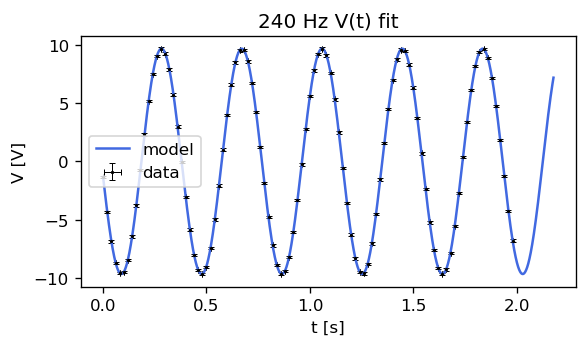





2-3_200Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $      9.67223 \pm      0.03033 $
For parameter f        :     $      0.97676 \pm      0.00046 $
For parameter phi      :     $     -0.02212 \pm      0.00320 $
For parameter c        :     $      0.03991 \pm      0.02167 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min         714.55773525
Reduced χ² value       :     χ²_red           7.44330974
P-value                :     p-value          0.00000000
----------------------------------------------------------------------------------------------------------------



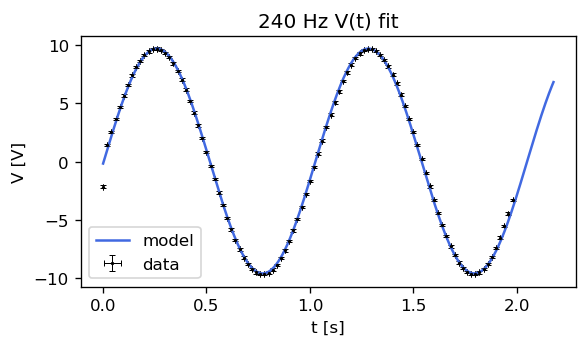





2-3_210Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $     -8.57964 \pm      0.03099 $
For parameter f        :     $      1.22119 \pm      0.00060 $
For parameter phi      :     $     -1.53197 \pm      0.00353 $
For parameter c        :     $     -0.34964 \pm      0.02167 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min       38379.70489311
Reduced χ² value       :     χ²_red         399.78859264
P-value                :     p-value          0.00000000
----------------------------------------------------------------------------------------------------------------



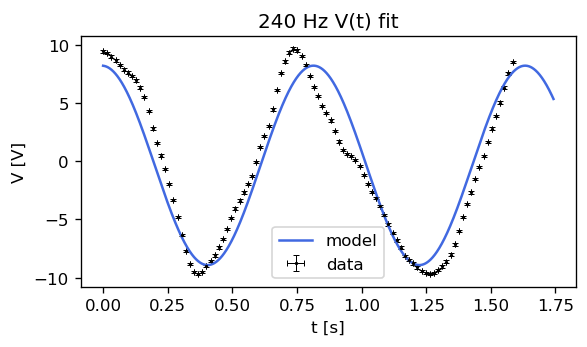





2-3_220Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $      9.69530 \pm      0.03066 $
For parameter f        :     $      1.59376 \pm      0.00024 $
For parameter phi      :     $     -2.93694 \pm      0.00316 $
For parameter c        :     $      0.00297 \pm      0.02167 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min          26.91493486
Reduced χ² value       :     χ²_red           0.28036390
P-value                :     p-value          1.00000000
----------------------------------------------------------------------------------------------------------------



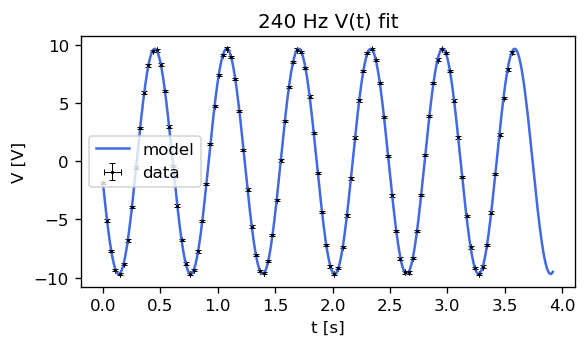





2-3_240Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $      9.83938 \pm      0.03075 $
For parameter f        :     $      1.54819 \pm      0.00026 $
For parameter phi      :     $     -1.66139 \pm      0.00310 $
For parameter c        :     $      0.01605 \pm      0.02167 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min         112.52870091
Reduced χ² value       :     χ²_red           1.17217397
P-value                :     p-value          0.11939316
----------------------------------------------------------------------------------------------------------------



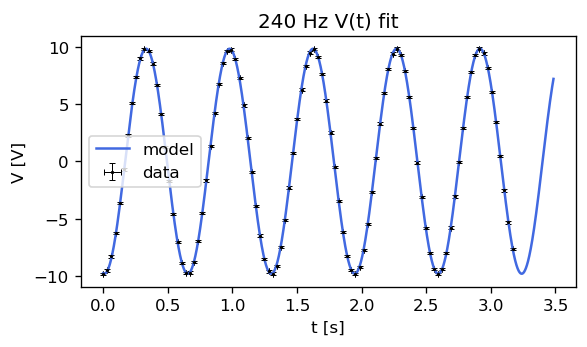

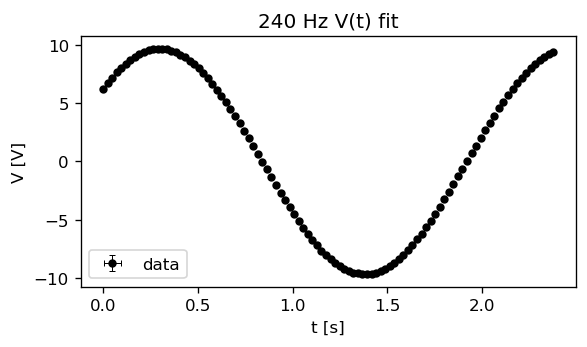

2-3_280Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $      9.63326 \pm      0.03938 $
For parameter f        :     $      0.08179 \pm      0.00023 $
For parameter phi      :     $     -1.03920 \pm      0.00340 $
For parameter c        :     $      0.13138 \pm      0.02519 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min           5.13662382
Reduced χ² value       :     χ²_red           0.07338034
P-value                :     p-value          1.00000000
----------------------------------------------------------------------------------------------------------------



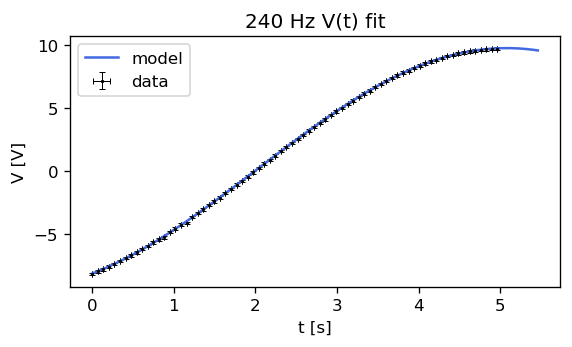





2-3_300Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $      9.66249 \pm      0.03150 $
For parameter f        :     $      0.38783 \pm      0.00023 $
For parameter phi      :     $      4.74063 \pm      0.00309 $
For parameter c        :     $      0.04182 \pm      0.02167 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min          98.20719207
Reduced χ² value       :     χ²_red           1.02299158
P-value                :     p-value          0.41834437
----------------------------------------------------------------------------------------------------------------



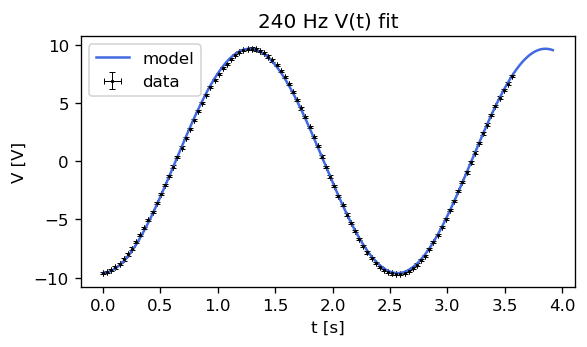

In [22]:
ERROR = 0.10
files = []
files_opdracht2 = []
for key in datadict:
    if key[0:3] == "2-3":
        files.append(fp.Data(datadict[key].x[:100], datadict[key].y[:100], ERROR*datadict[key].dy[:100], name=datadict[key].name))

def sinus_model(params, x):
    A,f,phi,c = params
    return A*np.sin(2*np.pi*f*x + phi) + c

        
for dataset in files:
    A = 10
    f = 1
    phi = -np.pi/4
    c = 1

    file_p = os.path.join(os.path.abspath(os.getcwd()), "data", "guesses_opgave3.txt")
    vals = []
    var = None
    check = True

    with open(file_p, "r") as file:
        for line in file:
            vals.append((line.strip().split(": ")[0],tuple(map(float, line.strip().split(": ")[-1].strip("()").split(", ")))))
    for var in vals:
        if var[0] == dataset.name:
            A, f, phi, c = var[1]
            check = False

    # dataset.show()
    try:
        dataset_new = dataset.fit(sinus_model, initial_guess=[A, f, phi, c])
        files_opdracht2.append(dataset_new)
        if dataset_new.chi2_red > 10:
            check = False
                
        if check:
            values = tuple([_ for _ in dataset_new.minima])
            with open(file_p, "a") as file:
                file.write(f"{dataset.name}: {values}\n")

        # WARNING: shows all fits
        if dataset_new.chi2_red > 0:
            print(dataset.name)
            print(dataset_new)
            dataset_new.show(size=1, title='240 Hz V(t) fit', x_label='t [s]', y_label='V [V]')
            print("\n\n\n")
    except ValueError:
        dataset.show(title='240 Hz V(t) fit', x_label='t [s]', y_label='V [V]')

In [7]:
[ 9.69685,9.67223,9.69530,9.83938, 9.69660 , 9.63326,9.66249]

[9.69685, 9.67223, 9.6953, 9.83938, 9.6966, 9.63326, 9.66249]

2-4_100Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $      9.84489 \pm      0.01525 $
For parameter f        :     $      1.85980 \pm      0.00022 $
For parameter phi      :     $     -1.46925 \pm      0.00156 $
For parameter c        :     $      0.00909 \pm      0.01083 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min          29.26659289
Reduced χ² value       :     χ²_red           0.30486034
P-value                :     p-value          1.00000000
----------------------------------------------------------------------------------------------------------------



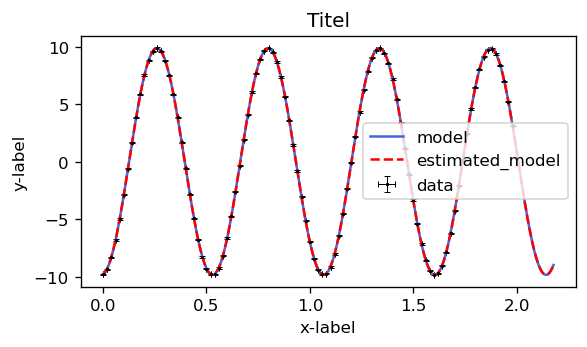





2-4_150Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $      9.85144 \pm      0.01477 $
For parameter f        :     $      0.82767 \pm      0.00023 $
For parameter phi      :     $     -2.15689 \pm      0.00162 $
For parameter c        :     $      0.00248 \pm      0.01083 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min          32.93121812
Reduced χ² value       :     χ²_red           0.34303352
P-value                :     p-value          1.00000000
----------------------------------------------------------------------------------------------------------------



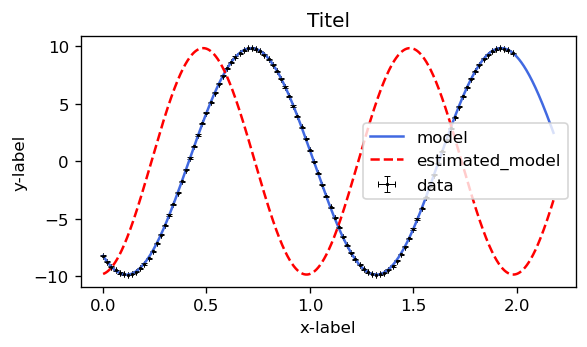





2-4_160Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $      9.84261 \pm      0.01550 $
For parameter f        :     $      0.54160 \pm      0.00010 $
For parameter phi      :     $     -0.60705 \pm      0.00154 $
For parameter c        :     $      0.01075 \pm      0.01083 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min          33.65578005
Reduced χ² value       :     χ²_red           0.35058104
P-value                :     p-value          1.00000000
----------------------------------------------------------------------------------------------------------------



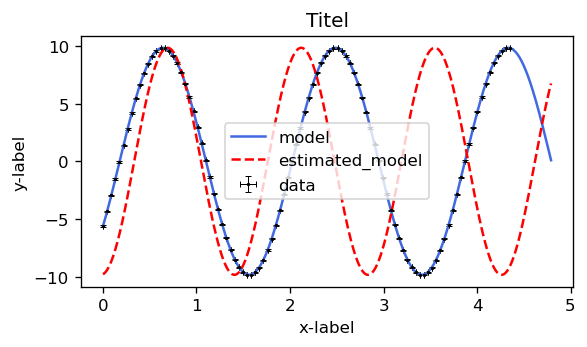





2-4_170Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $      9.84352 \pm      0.01533 $
For parameter f        :     $      3.32871 \pm      0.00037 $
For parameter phi      :     $     -4.33654 \pm      0.00156 $
For parameter c        :     $      0.00806 \pm      0.01083 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min          38.83956774
Reduced χ² value       :     χ²_red           0.40457883
P-value                :     p-value          0.99999997
----------------------------------------------------------------------------------------------------------------



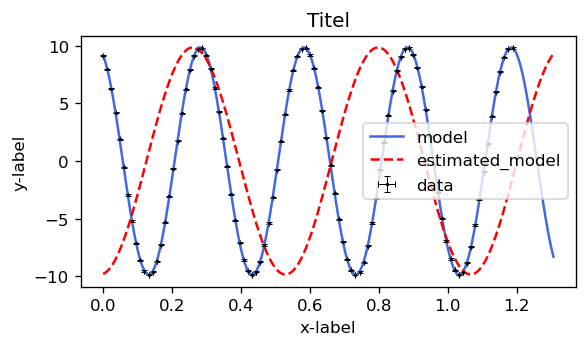





2-4_180Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $      9.85356 \pm      0.01488 $
For parameter f        :     $      0.59138 \pm      0.00016 $
For parameter phi      :     $      0.77835 \pm      0.00160 $
For parameter c        :     $     -0.02997 \pm      0.01083 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min         166.41403328
Reduced χ² value       :     χ²_red           1.73347951
P-value                :     p-value          0.00001112
----------------------------------------------------------------------------------------------------------------



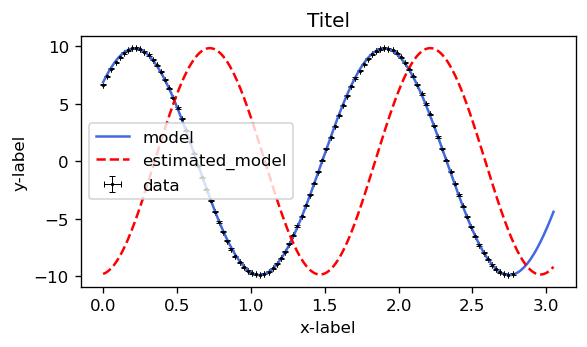





2-4_190Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $     -9.85181 \pm      0.01494 $
For parameter f        :     $      1.73338 \pm      0.00028 $
For parameter phi      :     $      6.86555 \pm      0.00160 $
For parameter c        :     $      0.01055 \pm      0.01083 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min          81.44559553
Reduced χ² value       :     χ²_red           0.84839162
P-value                :     p-value          0.85541319
----------------------------------------------------------------------------------------------------------------



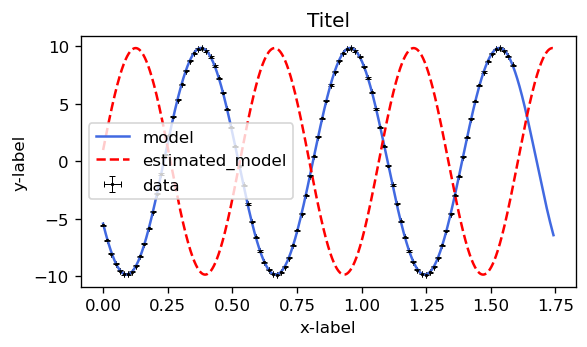





2-4_195Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $      9.87574 \pm      0.01517 $
For parameter f        :     $      0.56790 \pm      0.00012 $
For parameter phi      :     $      1.32294 \pm      0.00157 $
For parameter c        :     $      0.13299 \pm      0.01083 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min       12609.82703314
Reduced χ² value       :     χ²_red         131.35236493
P-value                :     p-value          0.00000000
----------------------------------------------------------------------------------------------------------------



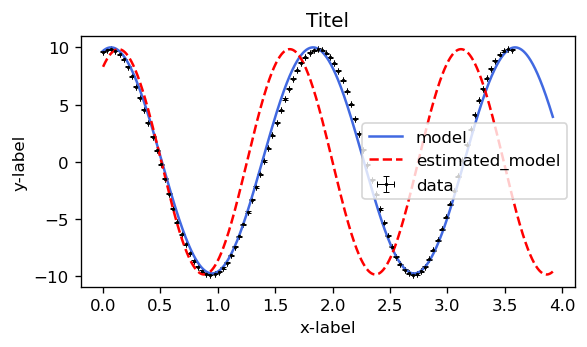





2-4_200Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $      9.71722 \pm      0.01486 $
For parameter f        :     $      0.56936 \pm      0.00022 $
For parameter phi      :     $      0.69845 \pm      0.00163 $
For parameter c        :     $      0.18513 \pm      0.01083 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min        5071.31872684
Reduced χ² value       :     χ²_red          52.82623674
P-value                :     p-value          0.00000000
----------------------------------------------------------------------------------------------------------------



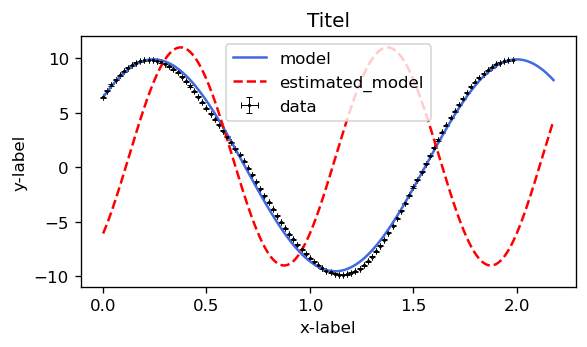





2-4_250Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $      4.19099 \pm      0.01605 $
For parameter f        :     $      0.58769 \pm      0.00016 $
For parameter phi      :     $     -2.90891 \pm      0.00388 $
For parameter c        :     $     -0.40009 \pm      0.01142 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min     1486070.98188250
Reduced χ² value       :     χ²_red       17279.89513817
P-value                :     p-value          0.00000000
----------------------------------------------------------------------------------------------------------------



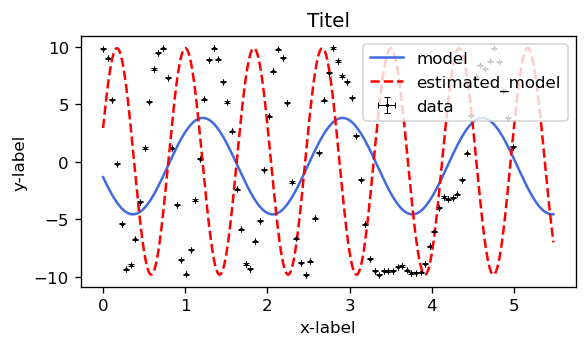





2-4_300Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $      9.79323 \pm      0.01525 $
For parameter f        :     $      0.43044 \pm      0.00013 $
For parameter phi      :     $      1.15324 \pm      0.00157 $
For parameter c        :     $      0.23703 \pm      0.01083 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min        3025.95223229
Reduced χ² value       :     χ²_red          31.52033575
P-value                :     p-value          0.00000000
----------------------------------------------------------------------------------------------------------------



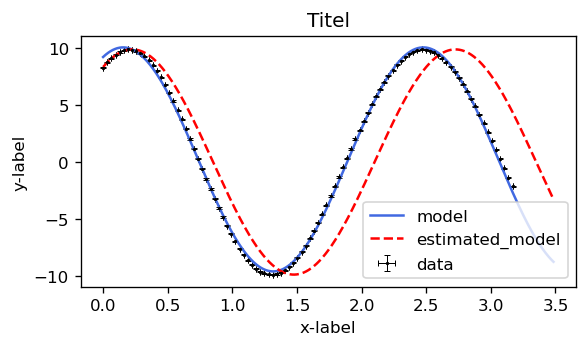

In [8]:
ERROR = 0.05
files = []
files_opdracht2 = []
for key in datadict:
    if key[0:3] == "2-4":
        files.append(fp.Data(datadict[key].x[:100], datadict[key].y[:100], ERROR*datadict[key].dy[:100], name=datadict[key].name))

def sinus_model(params, x):
    A,f,phi,c = params
    return A*np.sin(2*np.pi*f*x + phi) + c

        
for dataset in files:
    A = 10
    f = 1
    phi = -np.pi/4
    c = 1

    file_p = os.path.join(os.path.abspath(os.getcwd()), "Data", "guesses_opgave4.txt")
    vals = []
    var = None
    check = True

    with open(file_p, "r") as file:
        for line in file:
            vals.append((line.strip().split(": ")[0],tuple(map(float, line.strip().split(": ")[-1].strip("()").split(", ")))))
    for var in vals:
        if var[0] == dataset.name:
            A, f, phi, c = var[1]
            check = False

    # dataset.show()
    try:
        dataset_new = dataset.fit(sinus_model, initial_guess=[A, f, phi, c])
        files_opdracht2.append(dataset_new)
        if dataset_new.chi2_red > 10:
            check = False
                
        if check:
            values = tuple([_ for _ in dataset_new.minima])
            with open(file_p, "a") as file:
                file.write(f"{dataset.name}: {values}\n")

        # WARNING: shows all fits
        if dataset_new.chi2_red > 0:
            print(dataset.name)
            print(dataset_new)
            dataset_new.show(size=1, fit_guess=True)
            print("\n\n\n")
    except ValueError:
        dataset.show()

2-5_100Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $     -9.84662 \pm      0.01540 $
For parameter f        :     $     -1.77097 \pm      0.00022 $
For parameter phi      :     $     28.59894 \pm      0.00155 $
For parameter c        :     $      0.00696 \pm      0.01083 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min          34.03548623
Reduced χ² value       :     χ²_red           0.35453631
P-value                :     p-value          1.00000000
----------------------------------------------------------------------------------------------------------------



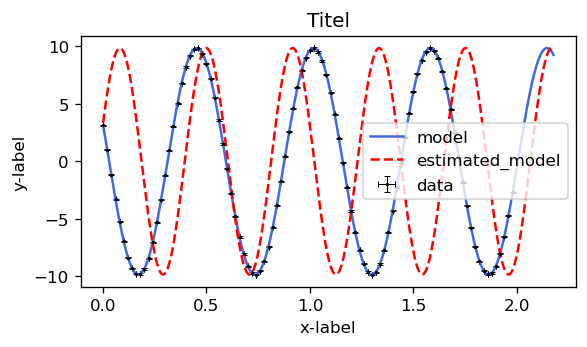





2-5_150Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $      9.84156 \pm      0.01481 $
For parameter f        :     $      1.11905 \pm      0.00023 $
For parameter phi      :     $      0.86756 \pm      0.00162 $
For parameter c        :     $      0.00476 \pm      0.01083 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min          28.03936636
Reduced χ² value       :     χ²_red           0.29207673
P-value                :     p-value          1.00000000
----------------------------------------------------------------------------------------------------------------



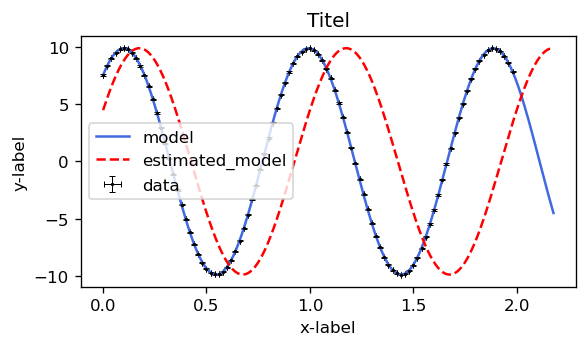





2-5_160Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $      9.84480 \pm      0.01543 $
For parameter f        :     $      1.85939 \pm      0.00010 $
For parameter phi      :     $     -0.67898 \pm      0.00155 $
For parameter c        :     $      0.00727 \pm      0.01083 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min          36.33523959
Reduced χ² value       :     χ²_red           0.37849208
P-value                :     p-value          1.00000000
----------------------------------------------------------------------------------------------------------------



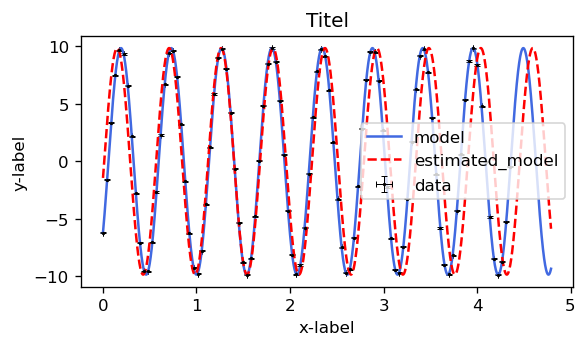





2-5_170Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $      9.84546 \pm      0.01520 $
For parameter f        :     $      2.74813 \pm      0.00036 $
For parameter phi      :     $     -1.79531 \pm      0.00157 $
For parameter c        :     $      0.01188 \pm      0.01083 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min          47.68060375
Reduced χ² value       :     χ²_red           0.49667296
P-value                :     p-value          0.99999117
----------------------------------------------------------------------------------------------------------------



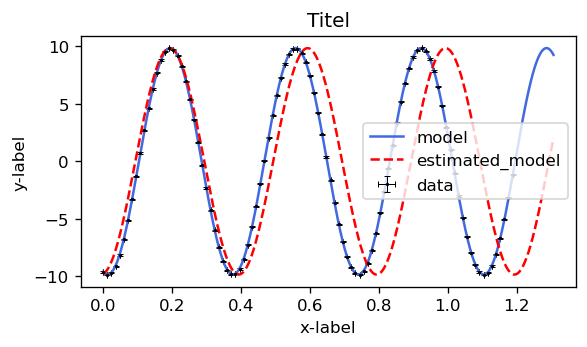





2-5_180Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $      9.84281 \pm      0.01539 $
For parameter f        :     $      1.62256 \pm      0.00015 $
For parameter phi      :     $      0.24712 \pm      0.00155 $
For parameter c        :     $     -0.07391 \pm      0.01083 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min        1784.32794289
Reduced χ² value       :     χ²_red          18.58674941
P-value                :     p-value          0.00000000
----------------------------------------------------------------------------------------------------------------



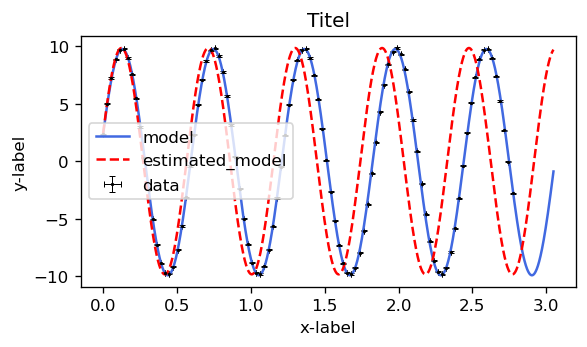





2-5_185Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $      9.84211 \pm      0.01669 $
For parameter f        :     $      0.67413 \pm      0.00010 $
For parameter phi      :     $     -0.28419 \pm      0.00170 $
For parameter c        :     $      0.01364 \pm      0.01182 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min          32.95873447
Reduced χ² value       :     χ²_red           0.41198418
P-value                :     p-value          0.99999933
----------------------------------------------------------------------------------------------------------------



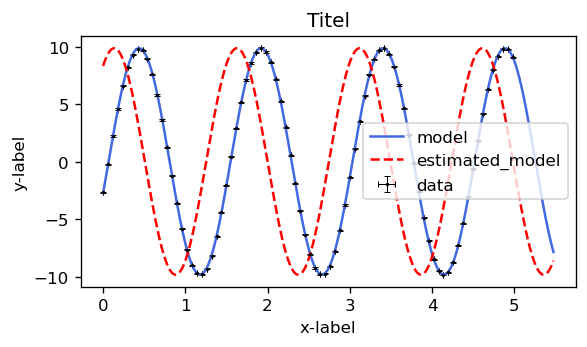





2-5_190Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $      9.84460 \pm      0.01515 $
For parameter f        :     $      1.73847 \pm      0.00028 $
For parameter phi      :     $     -2.94814 \pm      0.00157 $
For parameter c        :     $      0.00339 \pm      0.01083 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min          26.58983313
Reduced χ² value       :     χ²_red           0.27697743
P-value                :     p-value          1.00000000
----------------------------------------------------------------------------------------------------------------



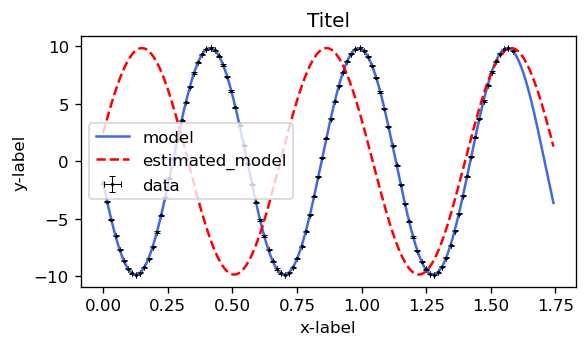





2-5_200Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $      9.73215 \pm      0.01544 $
For parameter f        :     $      0.72690 \pm      0.00023 $
For parameter phi      :     $     -0.85083 \pm      0.00156 $
For parameter c        :     $      0.11267 \pm      0.01083 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min         678.90366659
Reduced χ² value       :     χ²_red           7.07191319
P-value                :     p-value          0.00000000
----------------------------------------------------------------------------------------------------------------



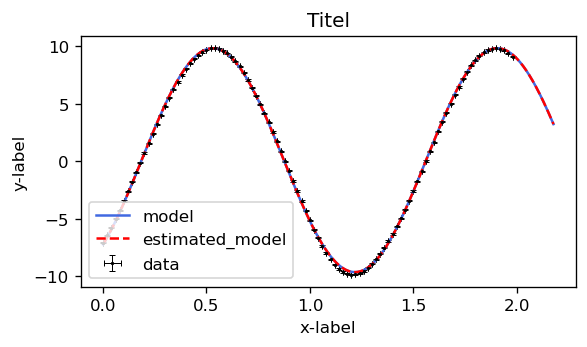

In [9]:
ERROR = 0.05
files = []
files_opdracht2 = []
for key in datadict:
    if key[0:3] == "2-5":
        files.append(fp.Data(datadict[key].x[:100], datadict[key].y[:100], ERROR*datadict[key].dy[:100], name=datadict[key].name))

def sinus_model(params, x):
    A,f,phi,c = params
    return A*np.sin(2*np.pi*f*x + phi) + c

        
for dataset in files:
    A = 10
    f = 1
    phi = -np.pi/4
    c = 1

    file_p = os.path.join(os.path.abspath(os.getcwd()), "data", "guesses_opgave5.txt")
    vals = []
    var = None
    check = True

    with open(file_p, "r") as file:
        for line in file:
            vals.append((line.strip().split(": ")[0],tuple(map(float, line.strip().split(": ")[-1].strip("()").split(", ")))))
    for var in vals:
        if var[0] == dataset.name:
            A, f, phi, c = var[1]
            check = False

    # dataset.show()
    try:
        dataset_new = dataset.fit(sinus_model, initial_guess=[A, f, phi, c])
        files_opdracht2.append(dataset_new)
        if dataset_new.chi2_red > 10:
            check = False
                
        if check:
            values = tuple([_ for _ in dataset_new.minima])
            with open(file_p, "a") as file:
                file.write(f"{dataset.name}: {values}\n")

        # WARNING: shows all fits
        if dataset_new.chi2_red > 0:
            print(dataset.name)
            print(dataset_new)
            dataset_new.show(size=1, fit_guess=True)
            print("\n\n\n")
    except ValueError:
        dataset.show()

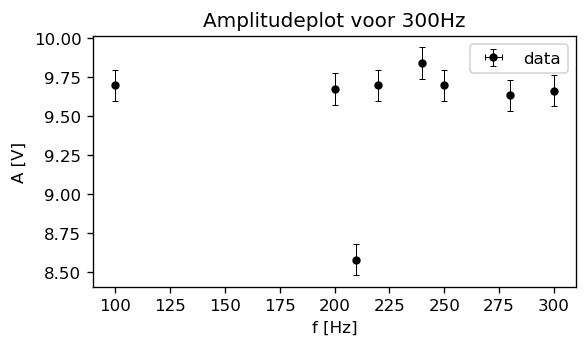

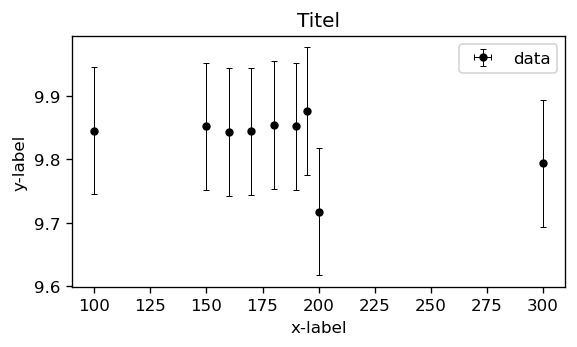

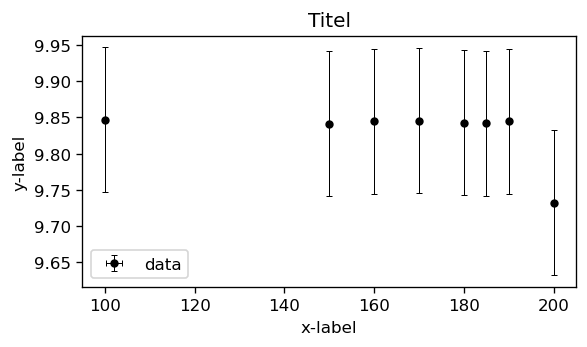

In [ ]:
A_300=[9.69685,  9.67223 ,8.57964 ,9.69530 , 9.83938,9.69660 ,9.63326 , 9.66249]
A_400=[ 9.84489,9.85144, 9.84261, 9.84352, 9.85356, 9.85181, 9.+7/, 9.71722, 9.79323 ]
A_500=[9.84662, 9.84156,9.84480, 9.84546, 9.84281, 9.84211, 9.84460,9.73215]
f_300=[100,200,210,220,240,250,280,300]
f_400=[100,150,160,170,180,190,195,200,300]
f_500=[100,150,160,170,180,185,190,200]
A_300err=np.ones_like(A_300)*0.1
A_400err=np.ones_like(A_400)*0.1
A_500err=np.ones_like(A_500)*0.1

data300=fp.Data(f_300, A_300, A_300err)
data400=fp.Data(f_400, A_400, A_400err)
data500=fp.Data(f_500, A_500, A_500err)

data300.show(title='Amplitudeplot voor 300Hz', x_label='f [Hz]', y_label='A [V]')
data400.show()
data500.show()